# Holiday Analysis

## Supporting Code, Connections & Packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

import psycopg2

In [2]:
# Function to place Postgres query into Pandas dataframe

def query_pandas(query, rollback_before, rollback_after):
    
    if rollback_before:
        pgsql.rollback()
    
    df = pd.read_sql_query(query, pgsql)
    
    if rollback_after:
        pgsql.rollback()
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
# Connection to Postgres database

pgsql = psycopg2.connect(
    user = "redacted",
    password = "redacted",
    host = "redacted",
    port = "redacted",
    database = "redacted"
    )

In [4]:
cursor = pgsql.cursor()

# Prompt

Acme Gourmet Meals (AGM) is a company that specializes in healthy, gourmet quality meals freshly fixed in containers. Products are marketed and sold at high-end grocery stores in five locations (Berkeley, CA; Dallas, TX; Miami, Fl; Nashville, TN; and Seattle, WA).

Meals are sold at a flat rate of twelve dollars per meal with no minimum. Since the food has to be heated before eating, it is not subject to sales tax. Customers must order by 10 AM one day in order to pick up the meals the next day.

AGM has just finished a very successful year on the enhanced computer systems, and now has a database of sales data for one year.

#### How do holidays affect the sales, considering both the actual holiday, and the days before and after the holiday? 

#### Create an executive summary explaining how holidays have affected sales. 

# Executive Summary

To determine how holidays impact AGM meal sales, in-depth analyses were performed; first, by looking at daily sales performance grouped by month, and then, by diving down to the weekly and day-to-day granularities. The monthly analysis provided a window into how weekly sales cycle with, and without, holidays (Appendix 2.2.1); however, a more comprehensive insight was derived when viewed strictly from the weekly level. A day-to-day benchmark 'non-holiday' average was compared against each day in a week containing a holiday, as well as the week before/after a holiday, to measure the full impact of holiday sales (Appendix 3.2.2).

Although holiday sales (excluding Veterans Day and closed days) were lower than the benchmark non-holiday day average, it is important to examine the implications of which day a holiday may fall on, as well as how holidays themselves are treated differently. Customer behaviors are primarily shaped around three holiday types: federal holidays, non-federal holidays, and 'Giving Season' holidays. The following category breakdowns provide more detail into what was observed in the dataset (covers only CY 2020).

- **Federal Holidays:** Federal holidays are often employer-paid, with the majority falling on or near weekends in 2020. Customers typically take time off work and/or travel during federal holidays that are juxtaposed to weekends, thereupon impacting meal sales on and around these holidays. Whether a weekend explodes into life with a Friday holiday, or quietly fades into a Monday holiday, the entire weekend experiences a decrease in sales. Sales typically return to normal by Tuesday of the following week; this is true even though Tuesday sales average the lowest (Appendix 3.2.1). Veterans Day is the only holiday under the Federal Holidays grouping that behaves differently, with sales on this day performing above the benchmark.


- **Non-Federal Holidays:** Non-Federal holidays all fall on Sundays and are not typically employer-paid. Customers are less likely to take time off or travel. AGM sales are only impacted the day of the holiday, performing at less than 50% of the benchmark average sales (Appendix 5.1.1). It should be noted that Sunday is one of the highest-grossing days for AGM. Days immediately before and after the holiday see normal sales, with both days also beating the benchmark average. Holidays in this category include Easter, Mother's Day and Father's Day.


- **'Giving Season' Holidays:** Due to Thanksgiving, Christmas, and New Year’s being mass-commercialized, customers are more likely to spend money in the spirit of giving. Meal sales do not experience an overall increase or decrease in November and December (Appendix 2.1.1), though the days before and after the holidays still perform above the benchmark. AGM stores are closed on Thanksgiving and Christmas Day, and New Year's Day performs at a third less sales than the average.

Based on the holiday findings, key recommendations are to increase marketing and discounts for AGM meals on and around holidays. Holiday-themed menu items should also be tailored toward the structure of the holidays. For example, on Non-Federal Holidays, AGM can create promotional menus in addition to offering discounts on the existing menu. Both should be marketed during the week leading up to the holiday. With Federal Holidays, the same marketing strategy should be implemented, with a final flash discount administered the day people are expected to return to their normal routine (i.e.; restocking groceries before going back to work).

To increase sales during the 'Giving Season' holiday months, heavy marketing should involve discounts on Black Friday, after Christmas, and directly before New Year's Day. These holidays are very food-centric and menu items such as potluck specials or multi-course meals could be impactful on sales.

The holiday analysis provided insight into potential opportunities. Although holiday sales performances are distinctly related to the type of holiday, AGM can develop strategies around marketing, promotions, and new menu items to profit from these distinctions.

# Data & Visualization Appendix

## 1. Variable & Data Preparation

In [5]:
# Set variables & lists

month_loop = ['January', 'February', 'March', 'April', 'May', 
              'June', 'July', 'August', 'September', 'October', 
              'November', 'December']
mo_num_loop = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dow_loop = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
dow_num = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}

In [6]:
# Set holiday dataframe

rollback_before = True
rollback_after = True

query = """

select holiday_date, 
    description,
    closed_flag,
    extract(dow from holiday_date) as dow,
    extract(week from holiday_date) as week_num
from holidays

"""

df_hol = query_pandas(query, rollback_before, rollback_after)
df_hol

,holiday_date,description,closed_flag,dow,week_num
0,2020-01-01,New Year's Day,False,3,1
1,2020-01-20,MLK Day,False,1,4
2,2020-02-17,President's Day,False,1,8
3,2020-04-12,Easter,False,0,15
4,2020-05-10,Mother's Day,False,0,19
5,2020-05-25,Memorial Day,False,1,22
6,2020-06-21,Father's Day,False,0,25
7,2020-07-04,Independence Day,False,6,27
8,2020-09-07,Labor Day,False,1,37
9,2020-11-11,Veterans Days,False,3,46


In [7]:
# Set holiday weeks as list

hol_wk = []

for hol in df_hol['week_num']:
    hol = int(hol)
    hol_wk.append(hol)
    
# Set holiday dates as list

hol_list = df_hol['holiday_date'].values.tolist()


# Set holiday description with holiday week number

hol_nam = df_hol[['week_num', 'description']]
hdesc = hol_nam.set_index('week_num').T.to_dict('list')

# Set holiday dates into list

hol_date = df_hol[['holiday_date']]
hol_date = hol_date.values.tolist()

In [8]:
# Create 2020 calendar dataframe

calendar = pd.date_range(start=date(2020, 1, 1),end=date(2020, 12, 31)).to_pydatetime()
cal_df = pd.DataFrame(calendar)
cal_df = cal_df.rename({0 : 'date'}, axis=1)

cal_df['day'] = cal_df['date'].dt.day_name()
cal_df['month'] = cal_df['date'].dt.month_name()
cal_df['mnum'] = cal_df['date'].dt.month
cal_df['day_count'] = 1
cal_df.head(5)

,date,day,month,mnum,day_count
0,2020-01-01,Wednesday,January,1,1
1,2020-01-02,Thursday,January,1,1
2,2020-01-03,Friday,January,1,1
3,2020-01-04,Saturday,January,1,1
4,2020-01-05,Sunday,January,1,1


In [9]:
# Remove holidays from counts

cal_dfnew = cal_df.drop(cal_df[cal_df['date'].isin(['2020-01-01','2020-01-20','2020-02-17',
                                                   '2020-04-12','2020-05-10','2020-05-25',
                                                   '2020-06-21','2020-07-04','2020-09-07',
                                                   '2020-11-11','2020-11-26','2020-12-25',])].index)

In [10]:
# Dataframe with number of days per year

daytable = pd.pivot_table(cal_dfnew, values='day_count', index=['day'], aggfunc=np.sum)
daytable = daytable.reset_index()

# Dataframe for days of week and day number

dow_numdf = pd.DataFrame(dow_num.items(), columns=['day','dow'])

# Join dataframes

df_counter = daytable.merge(dow_numdf, on='day')

## 2. Analysis by Month

The AGM dataset reflects customers, purchases, and spend amounts in 2020. The following section explores how holiday sales might show trends on a monthly basis. Total dollar amount is expressed in thousands of dollars.

### 2.1 Total Sales Amount by Day and Month

In [11]:
# Create dataframe for sales by date and month

rollback_before = True
rollback_after = True

query = """

select to_char(sale_date, 'Month') as month,
    extract(month from sale_date) as num_month,
    sale_date as date,
    round(sum(total_amount)/1000, 2) as total_sales
from sales
group by month, num_month, date
order by num_month, date

"""

df_tot = query_pandas(query, rollback_before, rollback_after)
df_tot.head(10)

,month,num_month,date,total_sales
0,January,1,2020-01-01,133.78
1,January,1,2020-01-02,261.12
2,January,1,2020-01-03,263.08
3,January,1,2020-01-04,400.37
4,January,1,2020-01-05,394.99
5,January,1,2020-01-06,262.02
6,January,1,2020-01-07,134.56
7,January,1,2020-01-08,259.90
8,January,1,2020-01-09,265.62
9,January,1,2020-01-10,265.16


In [12]:
# Create rows for holidays with no sales

df_miss = pd.DataFrame()

df_miss['month'] = ['November', 'December']
df_miss['num_month'] = [11, 12]
df_miss['date'] = ['2020-11-26', '2020-12-25']
df_miss['total_sales'] = [0, 0]

df_miss['date'] = pd.to_datetime(df_miss['date']).dt.date

In [13]:
# Add in holidays with no sales to holiday week dataframe

df_join = [df_tot, df_miss]
df_tot = pd.concat(df_join)

df_tot = df_tot.sort_values('date')
df_tot.reset_index(drop=True).head(10)

,month,num_month,date,total_sales
0,January,1,2020-01-01,133.78
1,January,1,2020-01-02,261.12
2,January,1,2020-01-03,263.08
3,January,1,2020-01-04,400.37
4,January,1,2020-01-05,394.99
5,January,1,2020-01-06,262.02
6,January,1,2020-01-07,134.56
7,January,1,2020-01-08,259.90
8,January,1,2020-01-09,265.62
9,January,1,2020-01-10,265.16


#### 2.1.1 Total Sales Amount by Day and Month Charts (Holidays Indicated by Red Color)

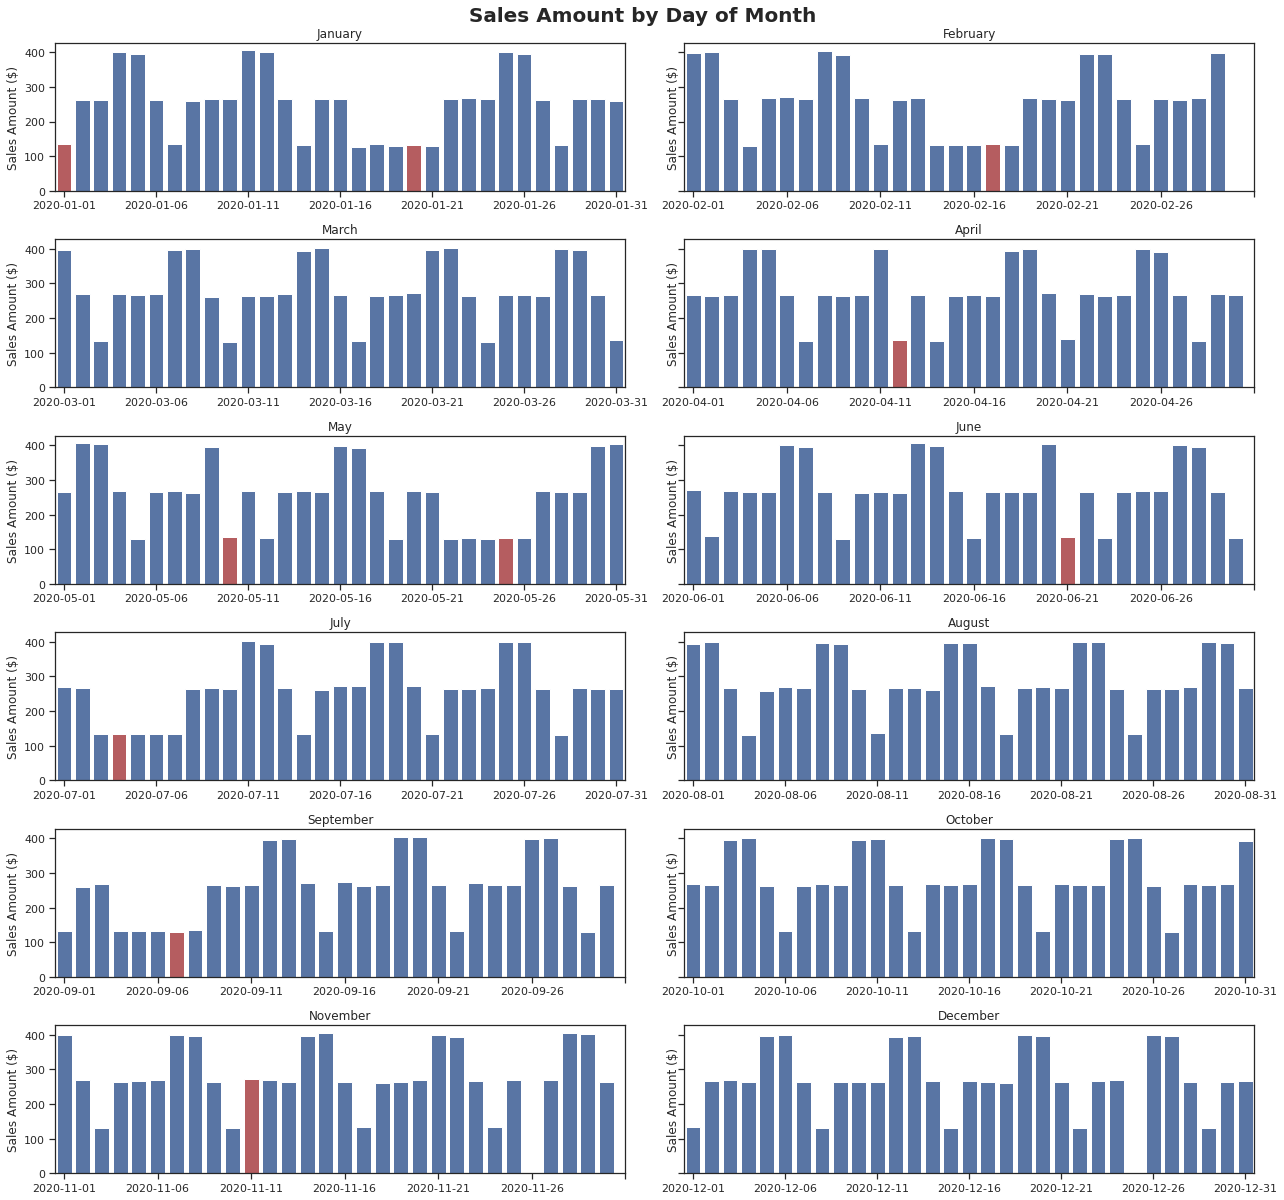

In [14]:
# Set function for plotting total sales by day and month, with holidays colored

def monthchart(df):

    sns.set(style='ticks')
    fig, axes = plt.subplots(6,2, figsize=(18,17), sharey=True)
    fig.subplots_adjust(hspace=0.7)
    fig.suptitle('Sales Amount by Day of Month', fontweight='bold', 
                 fontsize=20)

    for mo, ax in zip(mo_num_loop, axes.flatten()):
        month = ''
        
        for mth in mo_num_loop:
            if mth == mo:
                month = month_loop[mth-1:mth]
                month = ','.join(month)
        
        df_mo = df.loc[df['num_month'] == mo]

        sns.barplot(ax=ax, data=df_mo, x='date', y='total_sales', 
                    palette= ['r' if d in hol_list else 'b' for d in df_mo['date']])
        ax.set(title=''+month+'', xlabel='', ylabel='Sales Amount ($)', 
               xticks=np.arange(0,31, 5))
        
        fig.tight_layout()
    
        pass


monthchart(df_tot)

## 3. Analysis by Week & Weekday

It can be concluded from the above that the sales cycle is impacted by holidays, particularly on a week-to-week basis. The following section takes a deeper dive into weekly and day-to-day trends. Sales number and total dollar amount are based on thousands of units.

### 3.1 Sales Number and Total Dollar Amount by Weekday (Non-Holiday Days)

The total dollar amount in the table below will be used as the benchmark average to compare against days that are before, during, and after holidays.

In [15]:
# Query for number of sales and total sales amount by non-holiday day

rollback_before = True
rollback_after = True

query = """

select to_char(sale_date, 'Day') as day,
    extract(dow from sale_date) as dow,
    round(count(distinct sa.store_id || '' || sa.sale_id)/1000, 2) as num_sales,
    round(sum(quantity * 12)/1000, 2) as total_sales
from sales sa join line_items l on l.store_id = sa.store_id
            and l.sale_id = sa.sale_id
where date_part('week', sale_date) not in (select date_part('week', holiday_date) from holidays)
group by day, dow
order by dow

"""

df_non = query_pandas(query, rollback_before, rollback_after)
df_non

,day,dow,num_sales,total_sales
0,Sunday,0,231,14857.09
1,Monday,1,167,10775.81
2,Tuesday,2,84,5444.52
3,Wednesday,3,169,10879.82
4,Thursday,4,169,10908.35
5,Friday,5,157,10098.80
6,Saturday,6,231,14897.22


#### 3.1.1 Average Sales Amount by Weekday in 2020 (Non-Holiday Days)

In [16]:
# Calculate average sales by week days in year

df_day = df_non.merge(df_counter, on='dow')
df_day['avg_sales'] = df_day['total_sales']/df_day['day_count']

df_day = df_day.drop(['day_y','num_sales', 'total_sales'], axis=1)
df_day['avg_sales'] = df_day['avg_sales'].round(decimals=2)

df_day

,day_x,dow,day_count,avg_sales
0,Sunday,0,49,303.21
1,Monday,1,48,224.50
2,Tuesday,2,52,104.70
3,Wednesday,3,51,213.33
4,Thursday,4,52,209.78
5,Friday,5,51,198.02
6,Saturday,6,51,292.10


#### 3.1.2 Average Sales Amount by Weekday Chart (Non-Holiday Days)

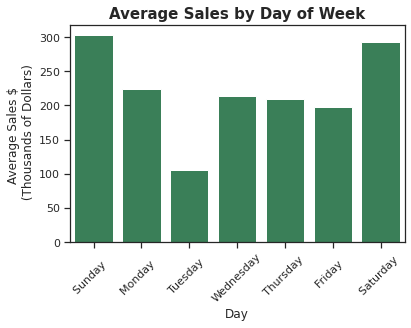

In [17]:
# Average sales by week day plot

sns.set(style='ticks')
sns.barplot(x='day_x',y='avg_sales', data=df_day, color='seagreen')
plt.title('Average Sales by Day of Week', fontweight='bold', fontsize='15')
plt.xticks(rotation=45)
plt.xlabel('Day', fontsize='12')
plt.ylabel('Average Sales $ \n (Thousands of Dollars)', fontsize='12')
pass

### 3.2 Total Dollar Amount by Day and Week (Holiday)

A separate dataframe is created with days that are before, during, and after holidays. Each day is grouped by week number of year. Total dollar amount is based on thousands of dollars.

#### 3.2.1 Two-Week Window: Before, During, and After Holidays Sales Figures

A two-week window is used to observe any lingering effects of holidays and the bounceback to a normal sales cycle.

In [18]:
# Query for holiday sales figures by week

rollback_before = True
rollback_after = True

query = """

select to_char(sale_date, 'Day') as day,
    sale_date as date,
    extract('dow' from sale_date) as dow,
    extract(week from sale_date) as week_num,
    round(sum(quantity * 12)/1000, 2) as total_sales
from sales sa join line_items l on l.store_id = sa.store_id
            and l.sale_id = sa.sale_id
where (extract(week from sale_date) in (select extract(week from holiday_date) from holidays)
    or extract(week from sale_date) in (select extract(week from holiday_date) + 1 from holidays)
    or extract(week from sale_date) in (select extract(week from holiday_date) - 1 from holidays))
group by day, sale_date, dow, week_num
order by week_num, sale_date

"""

df_hwk = query_pandas(query, rollback_before, rollback_after)
df_hwk.head(10)

,day,date,dow,week_num,total_sales
0,Wednesday,2020-01-01,3,1,133.78
1,Thursday,2020-01-02,4,1,261.12
2,Friday,2020-01-03,5,1,263.08
3,Saturday,2020-01-04,6,1,400.37
4,Sunday,2020-01-05,0,1,394.99
5,Monday,2020-01-06,1,2,262.02
6,Tuesday,2020-01-07,2,2,134.56
7,Wednesday,2020-01-08,3,2,259.90
8,Thursday,2020-01-09,4,2,265.62
9,Friday,2020-01-10,5,2,265.16


In [19]:
# Create rows for holidays with no sales

df_tc = pd.DataFrame()

df_tc['day'] = ['Thursday', 'Friday']
df_tc['date'] = ['2020-11-26', '2020-12-25']
df_tc['dow'] = [4, 5]
df_tc['week_num'] = [48, 52]
df_tc['total_sales'] = [0, 0]

df_tc['date'] = pd.to_datetime(df_tc['date']).dt.date

In [20]:
# Add in holidays with no sales to holiday week dataframe

df_join = [df_hwk, df_tc]
df_hwk = pd.concat(df_join)

df_hwk = df_hwk.sort_values('date')
df_hwk.reset_index(drop=True)

# Merge average sales by week day dataframe into holiday week dataframe

df_hwk = df_hwk.merge(df_day, on='dow')

df_hwk = df_hwk.drop(['day_x', 'day_count', 'dow'], axis=1)
df_hwk['avg_sales'] = df_hwk['avg_sales'].round(decimals=2)
df_hwk = df_hwk.sort_values('date')

df_hwk.reset_index(drop=True).head(10)

,day,date,week_num,total_sales,avg_sales
0,Wednesday,2020-01-01,1,133.78,213.33
1,Thursday,2020-01-02,1,261.12,209.78
2,Friday,2020-01-03,1,263.08,198.02
3,Saturday,2020-01-04,1,400.37,292.10
4,Sunday,2020-01-05,1,394.99,303.21
5,Monday,2020-01-06,2,262.02,224.50
6,Tuesday,2020-01-07,2,134.56,104.70
7,Wednesday,2020-01-08,2,259.90,213.33
8,Thursday,2020-01-09,2,265.62,209.78
9,Friday,2020-01-10,2,265.16,198.02


#### 3.2.2 Plots Comparing Holiday 'Two-Week Windows Against Non-Holiday Benchmark Average

Holidays are marked in brick in the plots below, and the benchmark average is represented by the black line.

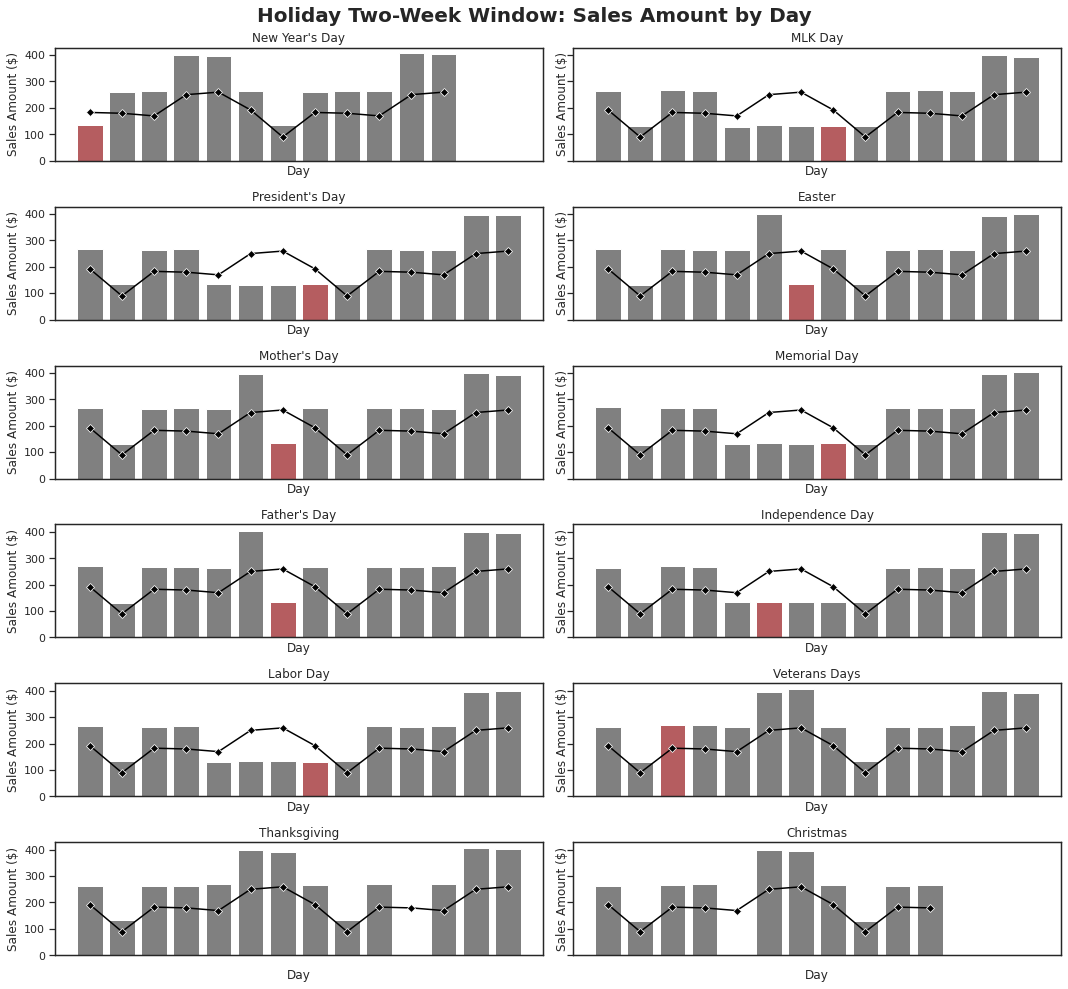

In [21]:
# Set function for plotting total sales by day of week, with benchmark and colored holidays

def weekchart(df):

    beg_hol = [4, 8, 22, 37, 48]
    end_hol = [1, 15, 19, 25, 27, 46, 52]

    sns.set(style='ticks')
    fig, axes = plt.subplots(6,2, figsize=(15,14), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.7)
    fig.suptitle('Holiday Two-Week Window: Sales Amount by Day', fontweight='bold', 
                 fontsize=20)

    for wk, ax in zip(hol_wk, axes.flatten()):
        week = ''
        wk2 = 0
             
        if wk in beg_hol:
            wk2 = wk - 1

        if wk in end_hol:
            wk2 = wk + 1

        df_wk = df.loc[df['week_num'].isin([wk,wk2])]
        
        for w in hdesc:
            if w == wk:
                week = hdesc.get(w)
                week = ','.join(week)

        sns.barplot(ax=ax, data=df_wk, x='date', y='total_sales', 
                    palette= ['r' if d in hol_list else 'grey' for d in df_wk['date']])
        ax.set(title=''+week+'', xlabel='Day', ylabel='Sales Amount ($)', 
               xticklabels=[])
        ax.tick_params(bottom=False)
        
        ax2 = ax.twinx()
        sns.lineplot(ax=ax2, data=df_wk, x=ax.get_xticks(), y='avg_sales', 
                     color='black', marker='D')
        ax2.set(ylabel='', xticklabels=[], yticklabels=[])
        ax2.set_ylim([0, 500])
        ax2.tick_params(right=False)
        ax2.grid(False)
        
        fig.tight_layout()

        pass

    
weekchart(df_hwk)

## 4. Analysis by Day (Before, During, and After Holiday)

The next section dials down to specific holidays and the days before and after. No time period windows are applied to check for lingering effects. The same non-holiday benchmark average is used for comparison. Total dollar amount is based on thousands of dollars.

### 4.1 Total Sales Amount by Day (Before, During, and After Holiday ONLY)

#### 4.1.1 Days Before, During, and After Holidays Sales Figures

In [22]:
# Query for sales performance for days before, during and after holiday

rollback_before = True
rollback_after = True

query = """

select to_char(sale_date, 'Day') as day,
    sale_date as date,
    extract('dow' from sale_date) as dow,
    date_part('week', sale_date) as week_num,
    round(sum(quantity * 12)/1000, 2) as total_sales
from sales sa join line_items l on l.store_id = sa.store_id
            and l.sale_id = sa.sale_id
where (sale_date in (select holiday_date from holidays)
    or sale_date in (select holiday_date + interval '1 day' from holidays)
    or sale_date in (select holiday_date - interval '1 day' from holidays))
group by day, sale_date, dow, week_num
order by sale_date

"""

df_hd = query_pandas(query, rollback_before, rollback_after)
df_hd.head(10)

,day,date,dow,week_num,total_sales
0,Wednesday,2020-01-01,3,1,133.78
1,Thursday,2020-01-02,4,1,261.12
2,Sunday,2020-01-19,0,3,130.37
3,Monday,2020-01-20,1,4,130.74
4,Tuesday,2020-01-21,2,4,129.86
5,Sunday,2020-02-16,0,7,132.18
6,Monday,2020-02-17,1,8,135.23
7,Tuesday,2020-02-18,2,8,133.26
8,Saturday,2020-04-11,6,15,400.12
9,Sunday,2020-04-12,0,15,136.16


In [23]:
# Add in holidays with no sales to holiday day dataframe

df_join = [df_hd, df_tc]
df_hd = pd.concat(df_join)

df_hd = df_hd.sort_values('date')
df_hd.reset_index(drop=True)

# Merge average sales by week day dataframe into holiday day dataframe

df_hd = df_hd.merge(df_day, on='dow')

df_hd = df_hd.drop(['day_x', 'day_count', 'dow'], axis=1)

df_hd = df_hd.sort_values('date')

df_hd.reset_index(drop=True).head(5)

,day,date,week_num,total_sales,avg_sales
0,Wednesday,2020-01-01,1,133.78,213.33
1,Thursday,2020-01-02,1,261.12,209.78
2,Sunday,2020-01-19,3,130.37,303.21
3,Monday,2020-01-20,4,130.74,224.50
4,Tuesday,2020-01-21,4,129.86,104.70


#### 4.1.2 Plots Comparing Days Before, During, and After Holidays Against Non-Holiday Benchmark Average

Holidays are marked in salmon in the plots below, and the benchmark average is represented by the black line.

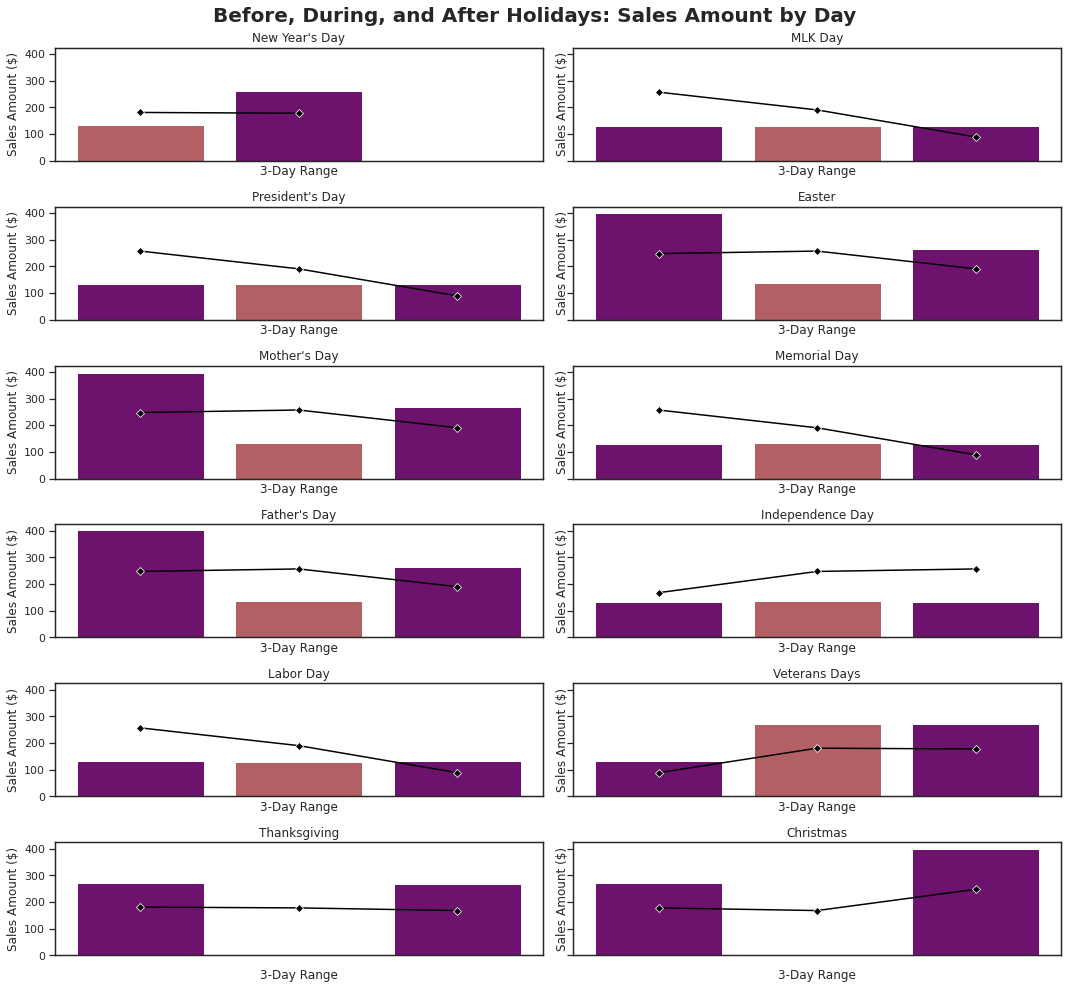

In [24]:
# Set function for plotting total sales by day, with benchmark and colored holidays

def daychart(df):

    beg_hol = [4, 8, 22, 37, 48]
    end_hol = [1, 15, 19, 25, 27, 46, 52]

    sns.set(style='ticks')
    fig, axes = plt.subplots(6,2, figsize=(15,14), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.7)
    fig.suptitle('Before, During, and After Holidays: Sales Amount by Day', fontweight='bold', 
                 fontsize=20)

    for wk, ax in zip(hol_wk, axes.flatten()):
        week = ''
        wk2 = 0
             
        if wk in beg_hol:
            wk2 = wk - 1

        if wk in end_hol:
            wk2 = wk + 1

        df_d = df.loc[df['week_num'].isin([wk,wk2])]
        
        for w in hdesc:
            if w == wk:
                week = hdesc.get(w)
                week = ','.join(week)

        sns.barplot(ax=ax, data=df_d, x='day', y='total_sales', 
                    palette= ['r' if d in hol_list else 'purple' for d in df_d['date']],
                    saturation=0.7)
        ax.set(title=''+week+'', xlabel='3-Day Range', ylabel='Sales Amount ($)', 
               xticklabels=[])
        ax.tick_params(bottom=False)
        
        ax2 = ax.twinx()
        sns.lineplot(ax=ax2, data=df_d, x=ax.get_xticks(), y='avg_sales', 
                     color='black', marker='D')
        ax2.set(ylabel='', xticklabels=[], yticklabels=[])
        ax2.set_ylim([0, 500])
        ax2.tick_params(right=False)
        ax2.grid(False)
        
        fig.tight_layout()

        pass
    

daychart(df_hd)

## 5. Percent Difference between Holiday Sales and Benchmark Sales

Compares as a percentage difference the total sales amount for each holiday against the average sales benchmark. Total dollar amount is expressed in thousands of dollars.

### 5.1 Total Sales Amount by Holiday Day

In [25]:
# Query for holiday days and sales performance

rollback_before = True
rollback_after = True

query = """

select description as holiday,
    to_char(sale_date, 'Day') as day,
    sale_date as date,
    extract('dow' from sale_date) as dow,
    round(sum(quantity * 12)/1000, 2) as total_sales
from sales sa join line_items l on l.store_id = sa.store_id
            and l.sale_id = sa.sale_id
            join holidays h on holiday_date = sale_date
where sale_date in (select holiday_date from holidays)
group by holiday, day, sale_date, dow
order by sale_date

"""

df_perc = query_pandas(query, rollback_before, rollback_after)
df_perc

,holiday,day,date,dow,total_sales
0,New Year's Day,Wednesday,2020-01-01,3,133.78
1,MLK Day,Monday,2020-01-20,1,130.74
2,President's Day,Monday,2020-02-17,1,135.23
3,Easter,Sunday,2020-04-12,0,136.16
4,Mother's Day,Sunday,2020-05-10,0,134.50
5,Memorial Day,Monday,2020-05-25,1,132.62
6,Father's Day,Sunday,2020-06-21,0,135.12
7,Independence Day,Saturday,2020-07-04,6,134.95
8,Labor Day,Monday,2020-09-07,1,130.02
9,Veterans Days,Wednesday,2020-11-11,3,271.92


#### 5.1.1 Percent Difference Between Holiday Sales Amount and Benchmark Sales Amount

Thanksgiving and Christmas holidays are closed for business.

In [26]:
# Add in holidays with no sales to holiday day dataframe

df_tc['holiday'] = ['Thanksgiving', 'Christmas']

df_join = [df_perc, df_tc]
df_perc = pd.concat(df_join)

df_perc = df_perc.sort_values('date')
df_perc.reset_index(drop=True)

# Merge average sales by week day dataframe into holiday day dataframe

df_perc = df_perc.merge(df_day, on='dow')

df_perc = df_perc.drop(['day_x', 'week_num', 'dow', 'day_count'], axis=1)

df_perc['perc_diff'] = np.where(df_perc['total_sales'] != 0, 
                                (-(df_perc['avg_sales'] - df_perc['total_sales']) 
                                 / df_perc['avg_sales'] * 100), 0)

df_perc['perc_diff'] = df_perc['perc_diff'].round(decimals=2)
df_perc['avg_sales'] = df_perc['avg_sales'].round(decimals=2)

df_perc = df_perc.reset_index(drop=True)

df_perc

,holiday,day,date,total_sales,avg_sales,perc_diff
0,New Year's Day,Wednesday,2020-01-01,133.78,213.33,-37.29
1,Veterans Days,Wednesday,2020-11-11,271.92,213.33,27.46
2,MLK Day,Monday,2020-01-20,130.74,224.50,-41.76
3,President's Day,Monday,2020-02-17,135.23,224.50,-39.76
4,Memorial Day,Monday,2020-05-25,132.62,224.50,-40.93
5,Labor Day,Monday,2020-09-07,130.02,224.50,-42.08
6,Easter,Sunday,2020-04-12,136.16,303.21,-55.09
7,Mother's Day,Sunday,2020-05-10,134.50,303.21,-55.64
8,Father's Day,Sunday,2020-06-21,135.12,303.21,-55.44
9,Independence Day,Saturday,2020-07-04,134.95,292.10,-53.80
